# Data analysis
This jupyter notebook will quanitfy and analyze the alpha generated by different actively managed mutual funds.  These mutual funds were chosen through a process that Richard will detail.

The goal of the project is two-fold.
- Determine the portion of returns for a given strategy that arises from exposure to various market or systematic risk factors
- Identify and quanityf the 'idiosyncratic alpha'

In [3]:
from tools import get_mutual_fund_data, get_bond_data, get_ff_data
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from data_tools import capm, ff_3, ff_5, reg_date_range

In [4]:
pd.set_option('display.max_rows', 10)

## Import data
First, we import data using the tools that Richard wrote.  This allows us to get mutual fund data in a dictionary.  In addition, we also want FF factors and CAPM factors to do some basic analysis

In [5]:
mf_dict = get_mutual_fund_data()
ff_df = get_ff_data()
bond_df = get_bond_data()


Mutual Fund Data
Total mutual fund categories:  20
Total number of rows:  8209

Bond Data
          date  30 Year Bond Return  ...  CPI Return  CPI Index Level
0   1961-01-31            -0.012612  ...    0.000000             70.1
1   1961-02-28             0.024233  ...    0.000000             70.1
2   1961-03-31            -0.000238  ...    0.000000             70.1
3   1961-04-30             0.015599  ...    0.000000             70.1
4   1961-05-31             0.009878  ...    0.000000             70.1
..         ...                  ...  ...         ...              ...
739 2022-08-31            -0.053490  ...   -0.000354            696.9
740 2022-09-30            -0.085155  ...    0.002151            698.4
741 2022-10-31            -0.065624  ...    0.004056            701.2
742 2022-11-30             0.077931  ...   -0.001010            700.5
743 2022-12-31            -0.035953  ...   -0.003070            698.3

[744 rows x 21 columns]


## Data set
Let us first take a look at our data set to see what we are working with.  We are only working with actively managed funds and primarily those with the largest AUM.

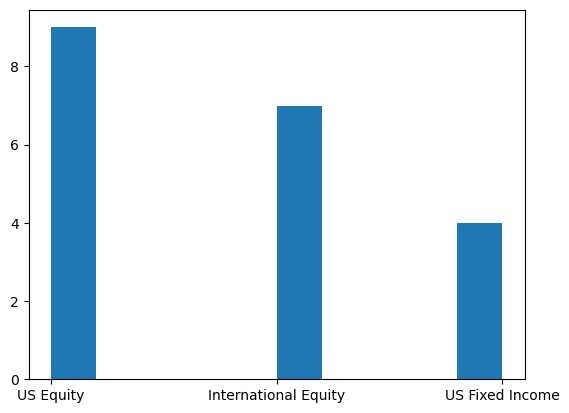

In [6]:
mf_types = list(mf_dict.keys())
mf_areas = [arr[0] for arr in mf_types]
plt.hist(mf_areas)
plt.show()

### Example df below

In [7]:
mf_dict[mf_types[10]]

,ticker,date,total_net_assets,total_returns,net_asset_value,nav_return
0,MDIDX,2004-10-31,15.300,0.026786,10.35,NaN
1,MDIDX,2004-11-30,41.200,0.065700,11.03,0.065700
2,MDIDX,2004-12-31,70.400,0.041922,11.41,0.034451
3,MDIDX,2005-01-31,94.600,-0.007888,11.32,-0.007888
4,MDIDX,2005-02-28,120.800,0.046820,11.85,0.046820
...,...,...,...,...,...,...
223,MDIDX,2023-05-31,3494.000,-0.035487,21.20,-0.035487
224,MDIDX,2023-06-30,3643.200,0.040566,22.06,0.040566
225,MDIDX,2023-07-31,3748.500,0.027199,22.66,0.027199
226,MDIDX,2023-08-31,3610.900,-0.033981,21.89,-0.033981


## US Equity
First, let us look at those actively managed US equity funds

### Get US Equity Data specifically

In [8]:
mf_types = list(mf_dict.keys())
us_eq_data = {k[1]: v for k, v in mf_dict.items() if 'US Equity' in k}
print(f'List of types of mutual funds being considered: {us_eq_data.keys()}')

List of types of mutual funds being considered: dict_keys(['Large Value', 'Large Blend', 'Large Growth', 'Mid Value', 'Mid Blend', 'Mid Growth', 'Small Value', 'Small Blend', 'Small Growth'])


### CAPM
First, we run CAPM on each to find their beta and alpha.  This gives us a good baseline with which to work off of.  

Note that these are run allowing for herteroskedasticity.  They are also run for the full range of dates for now

In [9]:
us_eq_alphas_c, us_eq_betas, us_eq_names = capm(us_eq_data, ff_df)

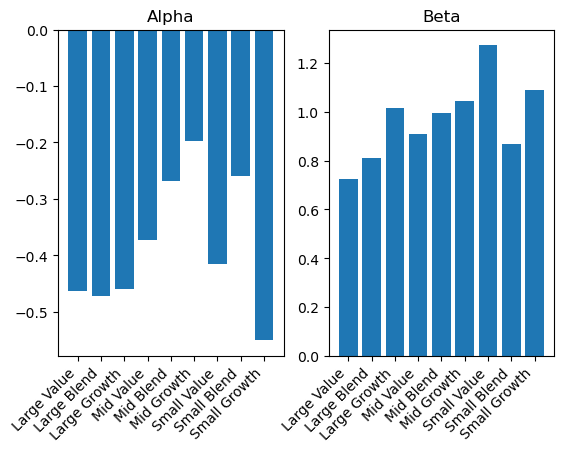

In [10]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
ax1.bar(us_eq_names, us_eq_alphas_c)
ax2.bar(us_eq_names, us_eq_betas)
fig.autofmt_xdate(rotation=45)
ax1.set_title('Alpha')
ax2.set_title('Beta')
plt.show()

### FF 3-Factor
This is the 3-factor model including SMB and HML

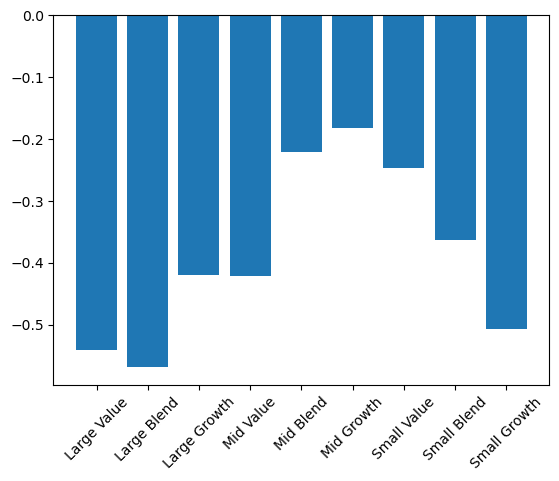

In [11]:
us_eq_alphas_3, us_eq_betas, us_eq_names, smbs, hmls = ff_3(us_eq_data, ff_df)
plt.bar(us_eq_names, us_eq_alphas_3)
plt.xticks(rotation=45)
plt.show()

### FF 5-Factor
This is the 3-factor model including SMB and HML.  RMW and CMA as well

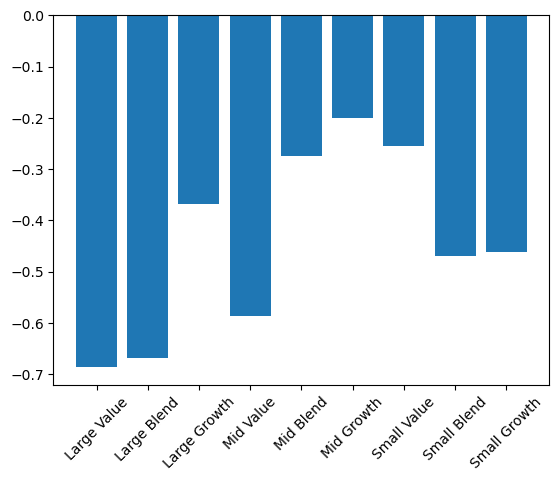

In [12]:
us_eq_alphas_5, us_eq_betas, us_eq_names, smbs, hmls, rmws, cmas = ff_5(us_eq_data, ff_df)
plt.bar(us_eq_names, us_eq_alphas_5)
plt.xticks(rotation=45)
plt.show()

### Combined bar graph of alpha from FF and CAPM

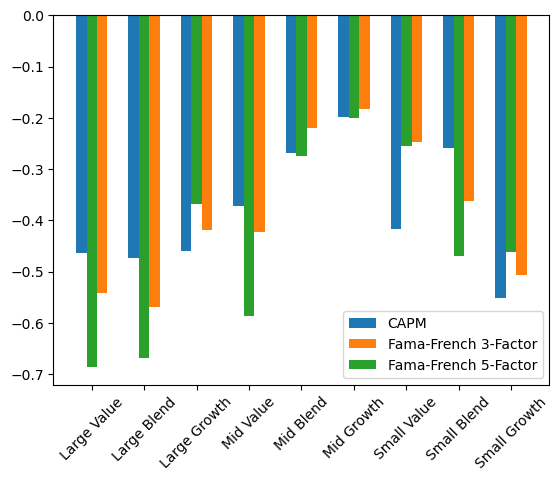

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)

idx = np.arange(len(us_eq_names))


ax.bar(idx-0.2, us_eq_alphas_c, 0.2, label='CAPM')
ax.bar(idx+0.2, us_eq_alphas_3, 0.2, label='Fama-French 3-Factor')
ax.bar(idx, us_eq_alphas_5, 0.2, label='Fama-French 5-Factor')

ax.set_xticks(idx)
ax.set_xticklabels(us_eq_names, rotation=45)
ax.legend()
plt.show()

### Find results from date range
We can now look at the results from a data range more specifically.  The function below is an example of being able to do that

Probably looking at a date range after GFC and before Covid has the least randomness or impact of systematic risk.  Could do more looking into regions of low vol.

In [19]:
reg_date_range(us_eq_data['Large Blend'], ff_df, ['Mkt-RF'], '20200101', '20220101')

{'const': -0.6726990959253201, 'Mkt-RF': 0.9060036420104239}

## International Equity
Next, we will look at international equity funds

### Get international Equity Data specifically

In [15]:
mf_types = list(mf_dict.keys())
int_data = {k[1]: v for k, v in mf_dict.items() if 'International Equity' in k}
print(f'List of types of mutual funds being considered: {int_data.keys()}')

List of types of mutual funds being considered: dict_keys(['Foreign Large Value', 'Foreign Large Blend', 'Foreign Large Growth', 'Foreign Small/Mid Value', 'Foreign Small/Mid Blend', 'Foreign Small/Mid Growth', 'Diversified Emerging Markets'])


### CAPM
First, we run CAPM on each to find their beta and alpha.  This gives us a good baseline with which to work off of.  

Note that these are run allowing for herteroskedasticity.  They are also run for the full range of dates for now

Also note that CAPM does not make a ton of sense here beacuse we are comparing international returns to the US markets, and how much it makes above that

In [16]:
int_alphas, int_betas, int_names = capm(int_data, ff_df)

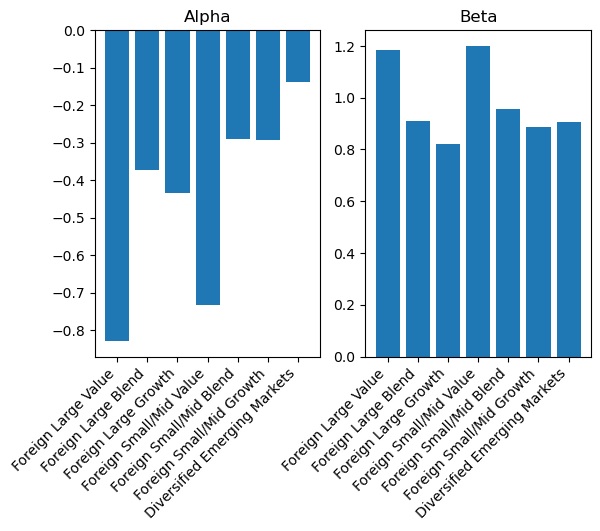

In [17]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
ax1.bar(int_names, int_alphas)
ax2.bar(int_names, int_betas)
fig.autofmt_xdate(rotation=45)
ax1.set_title('Alpha')
ax2.set_title('Beta')
plt.show()